# Lab 4: Cancer Detection

## Objective
* To build a dense prediction model
* To begin reading current papers in DNN research

## Deliverable
For this lab, you will turn in a notebook that describes your efforts at creating
a pytorch radiologist. Your final deliverable is a notebook that has (1) a deep network,
(2) method of calculating accuracy, 
(3) images that show the dense prediction produced by your network on the pos_test_000072.png image (index 172 in the validation dataset).
This is an image in the test set that your network will not have seen before.
This image, and the ground truth labeling, is shown below.
(And is contained in the downloadable dataset below).

<img src="http://liftothers.org/dokuwiki/lib/exe/fetch.php?t=1625096514&w=500&h=500&tok=f332aa&media=cs501r_f2016:pos_test_000072.png" width=200>

<img src="http://liftothers.org/dokuwiki/lib/exe/fetch.php?t=1625096514&w=500&h=500&tok=8b99f2&media=cs501r_f2016:pos_test_000072_output.png" width=200>

## Grading standards
Your notebook will be graded on the following:
* 40% Proper design, creation and debugging of a dense prediction network
* 20% Proper implementation of train/test set accuracy measure
* 20% Tidy visualizations of loss of your dense predictor during training
* 20% Test image output

## Dataset
The data is given as a set of 512x512 PNG images. Each input image (in the `inputs` directory) is an RGB image of a section of tissue, and there a file with the same name (in the `outputs` directory) that has a dense labeling of whether or not a section of tissue is cancerous (white pixels mean “cancerous”, while black pixels mean “not cancerous”).

The data has been pre-split for you into test and training splits. Filenames also reflect whether or not the image has any cancer at all (files starting with `pos_` have some cancerous pixels, while files starting with `neg_` have no cancer anywhere). All of the data is hand-labeled, so the dataset is not very large. That means that overfitting is a real possibility.

## Description
For a video including some tips and tricks that can help with this lab: [https://youtu.be/Ms19kgK_D8w](https://youtu.be/Ms19kgK_D8w) For this lab, you will implement a virtual radiologist. You are given images of possibly cancerous tissue samples, and you must build a detector that identifies where in the tissue cancer may reside.

## Part 0
Watch and follow video tutorial:

https://youtu.be/Ms19kgK_D8w

**TODO:**

**DONE:**
* ✅ Watch tutorial

# Part 1
Implement a dense predictor

In previous labs and lectures, we have talked about DNNs that classify an entire image as a single class. Here, however, we are interested in a more nuanced classification: given an input image, we would like to identify each pixel that is possibly cancerous. That means that instead of a single output, your network should output an “image”, where each output pixel of your network represents the probability that a pixel is cancerous.

___

Implement your network topology

Use the “Deep Convolution U-Net” from this paper: [(U-Net: Convolutional Networks for Biomedical Image Segmentation)](https://arxiv.org/pdf/1505.04597.pdf) 

<img src="https://lh3.googleusercontent.com/qnHiB3B2KRxC3NjiSDtY08_DgDGTDsHcO6PP53oNRuct-p2QXCR-gyLkDveO850F2tTAhIOPC5Ha06NP9xq1JPsVAHlQ5UXA5V-9zkUrJHGhP_MNHFoRGnjBz1vn1p8P2rMWhlAb6HQ=w2400" width=500>

You should use existing pytorch functions (not your own Conv2D module), such as ```nn.Conv2d``` and ```nn.CrossEntropyLoss```;
you will also need the pytorch function ```torch.cat``` and ```nn.ConvTranspose2d```

```torch.cat``` allows you to concatenate tensors.
```nn.ConvTranspose2d``` is the opposite of ```nn.Conv2d```.
It is used to bring an image from low res to higher res.
[This blog](https://towardsdatascience.com/up-sampling-with-transposed-convolution-9ae4f2df52d0) should help you understand this function in detail.

You can simplify the implementation of this lab by padding the feature maps as they pass through each convolution. This will make the concatenation process easier, though this is technically a departure from the cropping technique outlined in the orginal U-Net paper. 

**TODO:**

**DONE:**
* ✅ Understand concatenation of inputs from multiple prior layers
* ✅ Understand ConvTranspose
* ✅ Understand the U-Net architecture
* ✅ Answer Question / Reflect on simplest network with the desired properties (see section ["Question for thought"](#scrollTo=Question_for_thought) below)


___
The intention of this lab is to learn how to make deep neural nets. We'll help you with the implementation of the dataset.
This code will download the dataset for you so that you are ready to use it and focus on network implementation, losses and accuracies.

## Question for thought
Note that the simplest network you could implement (with all the desired properties) is just a single convolution layer with two filters and no relu! 
Why is that? (of course it wouldn't work very well!)

**My response**

The output needs to be an image where bright regions represent possible cancerous areas from the input image, and dark regions reprsent non-cancerous areas. A convolutional layer could process the input image and create an output of the same dimensions as the input, for example, using kernel_size=3, padding=1, stride=1 would produce an output the same size as the input.

Those kernels (filter maps) would produce a 2-channel output, as shown in the network architecture diagram above. Combining both filters, the network could recreate the dark and light areas of the output image by determining where the bright areas and dark areas are. For example, it could compare each pixel across the two channels and select the output pixel (light or dark) depending on which channel had the strongest (max) value at that pixel.

In [1]:
# Already installed by default in Google Colab, no need to install these packages
# !pip install torch
# !pip install torchvision
# !pip install tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, utils, datasets

import numpy as np
import matplotlib.pyplot as plt

# tqdm creates progress bars
from tqdm.notebook import tqdm

# pdb is a Python Debugger
# Set debugger trace, if needed, using pdb.set_trace()
# import pdb

# packages for working with files and the operating system,
# these are used to download the cancer images dataset
import os
import gzip
import tarfile

# The lines below help manage GPU memory
# garbage collector
import gc
# format tracebacks (exceptions)
from IPython.core.ultratb import AutoFormattedTB
# create a variable (__ITB__) to capture exceptions
__ITB__ = AutoFormattedTB(mode='Verbose', color_scheme='LightBg', tb_offset=1)

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

WARNING: You may run into an error that says "RuntimeError: CUDA out of memory."

In this case, the memory required for your batch is larger than what the GPU is capable of. You can solve this problem by adjusting the image size or the batch size and then restarting the runtime. 

## 💡 Tips for memory management
The GPU will have memory allocated for the dataloader (batches), the model (parameters), and the gradients. Those are the sources you may need to troubleshoot if you are running out of GPU memory.


* PyTorch (and Python) know that a variable will no longer be needed when that variable falls out of _scope_. So, it is important to define the PyTorch models (and any other tensor objects) within a scope that ends after code execution, so the variables can be released from memory.
 - Do that by wrapping the entire model-producing code (like the training loop) in a function, so that when you call the function and it finishes executing, the variables (including the model) will be released from memory
 - Make sure your function returns model performance information (loss and accuracy) so you can capture it to visualize the training metrics.
* With high-memory-taking batches (e.g., from high-res images), your GPU may be underutilized because it takes so much time to copy data from the CPU to the GPU for processing. You can speed up that process by copying the images to the GPU as `int`'s, rather than `float`'s, and then converting to a `float` and dividing by 255 (to scale b/t 0 and 1) on the GPU. See: https://youtu.be/Ms19kgK_D8w?t=2886.
* You can speed up the batch-loading process (esp. for training images) by assigning multiple CPU threads to simultaneously load the images for a batch. Just add `num_workers = number_of_cpu_threads` to the DataLoader constructor. See: https://youtu.be/Ms19kgK_D8w.
* You can look into the 3rd-party package `GPUtil`, which provides a function to check GPU utilization without calling `!nvidia-smi`, although calling that function in your network training loop will dramatically slow the loop.
* Search "IPython profiling" for tips on how to check the speed of code and find where bottlenecks might be. For example, [Jake VanderPlas has a helpful chapter on profiling](https://jakevdp.github.io/PythonDataScienceHandbook/01.07-timing-and-profiling.html)
* `.cuda()` is an in-place operation, so there is no need to do `tensor_x = tensor_x.cuda()` or `neural_net = neural_net.cuda()`.
* `torch.cuda.empty_cache()` can help, but only if PyTorch knows which variables no longer need memory allocation (it often holds onto variables for too long).
* Clean up unused variables (tensors) by calling `gc.collect()` before running the training loop
* Unhandled exceptions (like `KeyboardInterrupt`) cause memory leaks of they aren't caught
 - See code cells below for how to handle exceptions and reduce memory leaks

In [ ]:
# Handle exceptions to reduce memory leaks

# format tracebacks (exceptions)
from IPython.core.ultratb import AutoFormattedTB
# create a variable (__ITB__) to capture exceptions
__ITB__ = AutoFormattedTB(mode = 'Verbose', color_scheme='LightBg', tb_offset = 1)

try:
    # Clear unused variables from memory
    gc.collect()
    # run model
except:
    # View exception info (traceback)
    __ITB__()
    # Clear unused variables from memory
    gc.collect()

In [7]:
# Show how much memory the GPU is currently using
print(f'GPU memory used: {torch.cuda.memory_allocated(0) / 1e6:,.2f} MB')
print(f'GPU: {(torch.cuda.mem_get_info(0)[1] - torch.cuda.mem_get_info(0)[0]) / 1e6:,.0f}/{torch.cuda.mem_get_info(0)[1] / 1e6:,.0f} MB')

GPU memory used: 0.00 MB
GPU: 107/15,844 MB


In [8]:
!nvidia-smi

Sun Jan 30 03:45:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    27W /  70W |    102MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
# See: https://docs.python.org/3/library/multiprocessing.html#multiprocessing.cpu_count
# Also: https://thebinarynotes.com/python-multiprocessing/
# Show available CPUs on the system
# A dual-core CPU would have 2 threads, for the num_workers argument in DataLoader
import multiprocessing
print('CPU count:', multiprocessing.cpu_count())

CPU count: 2


In [10]:
# Show number of CPUs
import os
print('CPU count:', os.cpu_count())
print('Available CPUs:', len(os.sched_getaffinity(0)))

CPU count: 2
Available CPUs: 2


## Download datasets
This code is provided for you to help you focus on creating and training the model.

In [11]:
class CancerDataset(Dataset):
    def __init__(self, root, download=True, size=512, train=True):
        if download and not os.path.exists(os.path.join(root, 'cancer_data')):
            datasets.utils.download_url('http://liftothers.org/cancer_data.tar.gz', root, 'cancer_data.tar.gz', None)
            self.extract_gzip(os.path.join(root, 'cancer_data.tar.gz'))
            self.extract_tar(os.path.join(root, 'cancer_data.tar'))
    
        suffix = 'train' if train else 'test'
        root = os.path.join(root, 'cancer_data', 'cancer_data')
        self.dataset_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'inputs_' + suffix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))
        self.label_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'outputs_' + suffix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))

    # The staticmethod decorator (@staticmethod) indicates that this function
    # does not require the 'self' argument, that is, it does not depend
    # on a particular object.
    # Another way to think about it is that the function is class-level, not
    # object-level, so it is the same for every instance (object) of the class
    # See: https://youtu.be/Ms19kgK_D8w?t=2700
    @staticmethod
    def extract_gzip(gzip_path, remove_finished=False):
        print('Extracting {}'.format(gzip_path))
        # the 'with ___ as __:' construct is a context manager in Python
        # that automatically handles exceptions (e.g., try..finally blocks)
        # and closes objects when they leave scope (after the with block)
        # See: https://youtu.be/Ms19kgK_D8w?t=2800
        with open(gzip_path.replace('.gz', ''), 'wb') as out_f, gzip.GzipFile(gzip_path) as zip_f:
            out_f.write(zip_f.read())
        if remove_finished:
            os.unlink(gzip_path)
  
    @staticmethod
    def extract_tar(tar_path):
        print('Untarring {}'.format(tar_path))
        z = tarfile.TarFile(tar_path)
        z.extractall(tar_path.replace('.tar', ''))

    def __getitem__(self,index):
        img = self.dataset_folder[index]
        label = self.label_folder[index]
        return img[0],label[0][0]
  
    def __len__(self):
        return len(self.dataset_folder)

In [12]:
# ===============================================
# Initialize the train and validation datasets
# ===============================================
train_dataset = CancerDataset(root='/tmp/cancer_data', train=True)
val_dataset = CancerDataset(root='/tmp/cancer_data', train=False)

  0%|          | 0/2750494655 [00:00<?, ?it/s]

Extracting /tmp/cancer_data/cancer_data.tar.gz
Untarring /tmp/cancer_data/cancer_data.tar


## Define network architecture
_You'll probably want a function to test input / output sizes of the ConvTranspose2d layer_

### Convolutional size formulas

#### [Standard convolutions](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
**Formula for padding size**

$padding\_dim = \frac{output\_dim - input\_dim + kernel\_dim -1}{2}$

**Formula for output dimension**

$output\_dim = input\_dim + (padding\_dim × 2) - kernel\_dim + 1$

### [Transposed convolutions](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html)
**Formula for output dimensions**

$output\_dim = ((input\_dim - 1) × stride\_dim) - (2 × padding\_dim) + (dilation × (kernel\_dim - 1) + output\_padding\_dim + 1$

In [14]:
batch_size = 1
conv_type = 'transposed'    # or, 'standard'

# ==================
# Inputs
# ==================
in_channels = 1024
in_height = 64
in_width = 64

out_channels = 512
out_height = 128
out_width = 128

# Kernel, stride, padding, and output padding size
k_size = (2, 2)
s_size = (2, 2)
p_size = (0, 0)
op_size = (0, 0)

# Dilation
dil = 1

# ===================

def test_conv_output_size(batch_size, in_channels, out_channels, in_height, 
                          in_width, out_height, out_width, k_size, s_size, 
                          p_size, op_size, dil, conv_type='transposed'):
    if conv_type=='transposed':
        print('Transposed convolution\n======================')
        test_convT = nn.ConvTranspose2d(in_channels, out_channels, 
                            kernel_size=k_size, stride=s_size, padding=p_size, 
                            output_padding=op_size, dilation=dil)
        print('Expected:', 
            torch.zeros(batch_size, out_channels, out_height, out_width).size())
        print('Result:  ', 
            test_convT(torch.zeros(batch_size, in_channels, in_height, in_width)).size())
    else:
        print('Standard convolution\n====================')
        test_conv = nn.Conv2d(in_channels, out_channels, kernel_size=k_size, 
                            stride=s_size, padding=p_size, dilation=dil)
        print('Expected:', 
            torch.zeros(batch_size, out_channels, out_height, out_width).size())
        print('Result:  ', 
            test_conv(torch.zeros(batch_size, in_channels, in_height, in_width)).size())
    print('\nInputs:\n=======',
              f'\nConvolution type: {conv_type}',
              f'\nBatch size: {batch_size}',
              f'\nInput channels: {in_channels}',
              f'\nOutput channels: {out_channels}',
              f'\nInput height: {in_height}',
              f'\nInput width: {in_width}',
              f'\nOutput height: {out_height}',
              f'\nOutput width: {out_width}',
              f'\nKernel dimensions: {k_size}',
              f'\nStride dimensions: {s_size}',
              f'\nPadding dimensions: {p_size}',
              f'\nOutput padding dimensions: {op_size}',
              f'\nDilation: {dil}', sep='')

# Run function
test_conv_output_size(batch_size=batch_size, in_channels=in_channels, 
    out_channels=out_channels, in_height=in_height, in_width=in_width, 
    out_height=out_height, out_width=out_width, k_size=k_size, s_size=s_size, 
    p_size=p_size, op_size=op_size, dil=dil, conv_type=conv_type)

Transposed convolution
Expected: torch.Size([1, 512, 128, 128])
Result:   torch.Size([1, 512, 128, 128])

Inputs:
Convolution type: transposed
Batch size: 1
Input channels: 1024
Output channels: 512
Input height: 64
Input width: 64
Output height: 128
Output width: 128
Kernel dimensions: (2, 2)
Stride dimensions: (2, 2)
Padding dimensions: (0, 0)
Output padding dimensions: (0, 0)
Dilation: 1


### Define neural network class

In [13]:
# Since you will be using the output of one network in two places (convolution and maxpooling),
# you can't use nn.Sequential.
# Instead you will write up the network like normal variable assignment as the example shown below:
# You are welcome (and encouraged) to use the built-in batch normalization and dropout layers
# TODO: You need to change this to fit the UNet structure!!!

# ================================================
# For a helpful example on creating a network, 
# see: https://pytorch.org/tutorials/recipes/recipes/defining_a_neural_network.html
# Another idea: create a separate module for each "block" (repeated layers)
# and then link all of the modules together in an overall module that the model
# is created from.
class CancerDetection(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv01 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        # --> ReLU
        self.conv02 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        # --> ReLU
        # --> Skip connection: conv02 output is concatenated as add'l channels to conv21 using a skip connection
        # --> Maxpool
        self.conv03 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        # --> ReLU
        self.conv04 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        # --> ReLU
        # --> Skip connection: conv04 output is concatenated as add'l channels to conv18 using a skip connection
        # --> Maxpool
        self.conv05 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        # --> ReLU
        self.conv06 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        # --> ReLU
        # --> Skip connection: conv06 output is concatenated as add'l channels to conv15 using a skip connection
        # --> Maxpool
        self.conv07 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        # --> ReLU
        self.conv08 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        # --> ReLU
        # --> Skip connection: conv08 output is concatenated as add'l channels to conv12 using a skip connection
        # --> Maxpool
        self.conv09 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1)
        # --> ReLU
        self.conv10 = nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1)
        # --> ReLU
        # ---------------------------------------------------------
        # Begin upward part of network with Transposed Convolutions
        # ---------------------------------------------------------
        self.convT11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512,
                        kernel_size=2, stride=2, padding=0, output_padding=0, dilation=1)
        # --> Skip connection: Concat output from conv08
        self.conv12 = nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, stride=1, padding=1)
        # --> ReLU
        self.conv13 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        # --> ReLU
        self.convT14 = nn.ConvTranspose2d(in_channels=512, out_channels=256,
                        kernel_size=2, stride=2, padding=0, output_padding=0, dilation=1)
        # --> Skip connection: Concat output from conv06
        self.conv15 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1)
        # --> ReLU
        self.conv16 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        # --> ReLU
        self.convT17 = nn.ConvTranspose2d(in_channels=256, out_channels=128,
                        kernel_size=2, stride=2, padding=0, output_padding=0, dilation=1)
        # --> Skip connection: Concat output from conv04
        self.conv18 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1)
        # --> ReLU
        self.conv19 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        # --> ReLU
        self.convT20 = nn.ConvTranspose2d(in_channels=128, out_channels=64,
                        kernel_size=2, stride=2, padding=0, output_padding=0, dilation=1)
        # --> Skip connection: Concat output from conv02
        self.conv21 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1)
        # --> ReLU
        self.conv22 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        # --> ReLU
        self.conv23 = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=1, stride=1, padding=0)
        # --> Output


    def forward(self, input):
        # Here, I use the variable x at most steps to conserve memory
        # by not creating a new variable after each operation.
        # Note that I use nn.functional for ReLU and Maxpool operations in
        # between convolutional layers.

        # The  maxpool operations reduce size to 1/2
        # See: https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html
        # Note that default stride is the same as the kernel size

        # Input dimensions: (batch_count, channels, height, width)
        # E.g., (16, 3, 1024, 1024)

        x = self.conv01(input)
        x = nn.functional.relu(x)
        x = self.conv02(x)
        # Capture output, to concatenate later
        skip1 = nn.functional.relu(x)
        x = nn.functional.max_pool2d(skip1, kernel_size=2)
        x = self.conv03(x)
        x = nn.functional.relu(x)
        x = self.conv04(x)
        skip2 = nn.functional.relu(x)
        x = nn.functional.max_pool2d(skip2, kernel_size=2)
        x = self.conv05(x)
        x = nn.functional.relu(x)
        x = self.conv06(x)
        skip3 = nn.functional.relu(x)
        x = nn.functional.max_pool2d(skip3, kernel_size=2)
        x = self.conv07(x)
        x = nn.functional.relu(x)
        x = self.conv08(x)
        skip4 = nn.functional.relu(x)
        x = nn.functional.max_pool2d(skip4, kernel_size=2)
        x = self.conv09(x)
        x = nn.functional.relu(x)
        x = self.conv10(x)
        x = nn.functional.relu(x)
        # ---------------------------------------------------------
        # Begin upward part of network with Transposed Convolutions
        # ---------------------------------------------------------
        # To set the output_size directly, see: https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html
        x = self.convT11(x)
        # --> Skip connection: Concat output from skip4, along dimension 1 (channel)
        x = torch.cat((skip4, x), 1)
        x = self.conv12(x)
        x = nn.functional.relu(x)
        x = self.conv13(x)
        x = nn.functional.relu(x)
        x = self.convT14(x)
        # --> Skip connection: Concat output from skip3, along dimension 1 (channel)
        x = torch.cat((skip3, x), 1)
        x = self.conv15(x)
        x = nn.functional.relu(x)
        x = self.conv16(x)
        x = nn.functional.relu(x)
        x = self.convT17(x)
        # --> Skip connection: Concat output from skip2, along dimension 1 (channel)
        x = torch.cat((skip2, x), 1)
        x = self.conv18(x)
        x = nn.functional.relu(x)
        x = self.conv19(x)
        x = nn.functional.relu(x)
        x = self.convT20(x)
        # --> Skip connection: Concat output from skip1, along dimension 1 (channel)
        x = torch.cat((skip1, x), 1)
        x = self.conv21(x)
        x = nn.functional.relu(x)
        x = self.conv22(x)
        x = nn.functional.relu(x)
        x = self.conv23(x)
        # Output (x) is a 4-D tensor of shape (batch_count, 2, 1024, 1024)
        # There is no need to squeeze the output, since we are doing dense prediction
        return x

### 💡 Insight: data structure for loss computation
**Question:** The output of our model should be a tensor of shape `(batch_size, 2, 512, 512)`, right?
How will `CrossEntropyLoss` compare that to the `y_truth` tensor of shape `(batch_size, 512, 512)`?

**Answer,** from Connor Wilhelm (TA): Yes, those are the shapes that cross entropy loss expects. It uses the class labels to index into the channel dimension of `y_hat`.
In labs 2 and 3, cross entropy loss expected a `y_hat` with shape `(batch_size, num_classes)` containing real-valued class scores, and a `y_truth` with shape `(batch_size)` with integer class labels. This is the same, but with two spatial dimensions added after, so `y_hat` should be `(batch, num_classes, h, w)`  and `y_truth` should be `(batch, h, w)` with integer values from `[0, num_classes)`.

If you argmax y_hat along the channel dimension, you will get a tensor the same shape as y_truth, which represents the model's class predictions. Alternatively, you can use y_truth as indexes into y_hat's channel dimension, which gives you what cross entropy loss needs: the prediction scores for just the correct classes.

# Part 2: model performance

Plot performance over time

Please generate two plots:
* One that shows loss on the training and validation set as a function of training time (batches or iterations). 
* One that shows accuracy on the training and validation set as a function of training time (batches or iterations). 

Make sure your axes are labeled!

**TODO:**

**DONE:**
* ✅ Plot training/validation loss as function of training time (batches or iterations, not epochs)
* ✅ Plot training/validation accuracy as function of training time (batches or iterations, not epochs)



## Test code
Various tests I ran to check smaller portions of the production code.

### Test code: overfit model

In [30]:
def overfit_model(total_batches=100, input_index=172):
    # =================================
    # Initialize the validation dataset
    # =================================
    val_dataset = CancerDataset(root='/tmp/cancer_data', train=False)
    # Collect image to use for overfitting
    x, y_truth = val_dataset[input_index]
    # Load tensors on GPU
    x = x.cuda(non_blocking=True).unsqueeze(dim=0)
    print('Input size:', x.size())
    y_truth = y_truth.cuda(non_blocking=True).unsqueeze(dim=0)

    # ==================================================
    # Initialize model, loss (objective), and optimizer
    # ==================================================
    model = CancerDetection()
    model.cuda()
    print('Model loaded\n============')
    print(f'GPU memory used: {torch.cuda.memory_allocated(0) / 1e6:,.2f} MB')
    # Compute and print the number of parameters in the model
    # torch.numel = number of elements
    num_params = sum([torch.numel(layer) for layer in model.parameters()])
    print(f'Total parameters: {num_params:,d}')
    print('============================\n')

    # Set cost (loss) function to Cross Entropy Loss
    objective = nn.CrossEntropyLoss()
    # The optimizer minimizes the cost function
    optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)

    # =================
    # Run training loop
    # =================
    train_acc = []
    train_loss = []
    prog_bar = tqdm(total=total_batches, position=0, leave=True)
    prog_bar.set_description('Progress')

    for i in range(total_batches):
        # Zero-out gradient information so it can be updated with new gradient
        optimizer.zero_grad()
        # Make predictions
        y_hat = model(x)
        
        # Calculate loss
        loss = objective(y_hat, y_truth.long())
        train_loss.append(loss.item())

        # Collapse channels into 1 using argmax (representing the model's prediction)
        acc = ((y_hat.argmax(dim=1) == y_truth).float().mean().item())
        train_acc.append(acc)
        
        # Compute backpropagation
        loss.backward()
        # Take step, based on learning rate and gradient
        optimizer.step()

        # Update progress bar by 1 step
        prog_bar.set_description(f'Progress: {i+1}/{total_batches}, Acc: {acc:.0%}, Loss: {loss.item():.3f}, GPU: {(torch.cuda.mem_get_info(0)[1] - torch.cuda.mem_get_info(0)[0]) / 1e6:,.0f}/{torch.cuda.mem_get_info(0)[1] / 1e6:,.0f} MB, Progress')
        prog_bar.update(n=1)

    return train_acc, train_loss, model(x).argmax(dim=1).squeeze().detach().cpu().numpy(), model.cpu()

Run code to overfit the model

Input size: torch.Size([1, 3, 512, 512])
Model loaded
GPU memory used: 131.86 MB
Total parameters: 31,031,810



  0%|          | 0/200 [00:00<?, ?it/s]

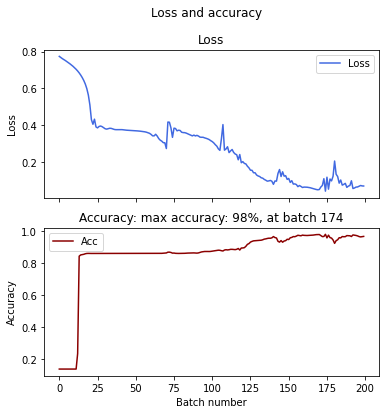

In [33]:
try:
    total_batches = 200
    # Run model
    train_acc, train_loss, output_img, model = overfit_model(total_batches=total_batches)
    # ========================
    # Plots: loss and accuracy
    # ========================
    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(6,6))
    batch_nums = [i for i in range(total_batches)]

    # Loss
    ax1.plot(batch_nums, train_loss, label='Loss', c='royalblue')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.set_title('Loss')

    # Accuracy
    ax2.plot(batch_nums, train_acc, label='Acc', c='darkred')
    ax2.set_xlabel('Batch number')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.set_title(f'Accuracy: max accuracy: {max(train_acc):.0%}, at batch {batch_nums[train_acc.index(max(train_acc))]}')

    fig.suptitle('Loss and accuracy')
    plt.show()
except:
    __ITB__()
    gc.collect()

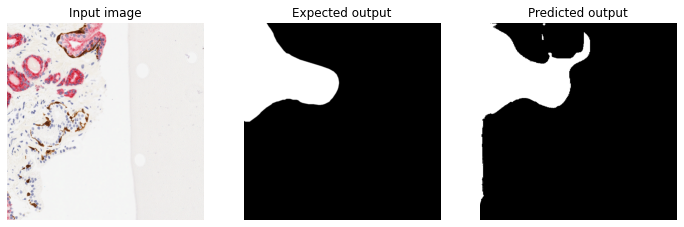

In [34]:
# Display output images
val_dataset = CancerDataset(root='/tmp/cancer_data', train=False)
x, y_truth = val_dataset[172]
input_img = x.numpy()
# imshow expects dimensions in the order: height x width x depth (channels)
# The x tensor comes in the shape (channels, height, width)
# See: https://stackoverflow.com/a/23944468/17005348
# Alternatively, keep the array as a Tensor and use Tensor.view to reshape its dimensions
input_img = np.transpose(input_img, (1, 2, 0))
expected_output_img = y_truth.numpy()

# Plot images
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(input_img)
plt.title('Input image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(expected_output_img, cmap='gray')
plt.title('Expected output')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(output_img, cmap='gray')
plt.title('Predicted output')
plt.axis('off')

plt.show()

### Test code: display input and output images

Output size after argmax on channels: torch.Size([1, 512, 512])
Output size after squeezing batch dimension: (512, 512)


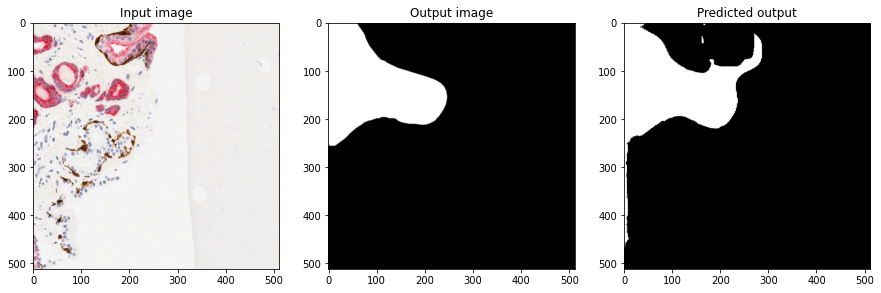

In [35]:
x, y_truth = val_dataset[172]
input_img = x.numpy()
# imshow expects dimensions in the order: height x width x depth (channels)
# See: https://stackoverflow.com/a/23944468/17005348
# Alternatively, keep the array as a Tensor and use Tensor.view
input_img = np.transpose(input_img, (1, 2, 0))
output_img = y_truth.numpy()


# Make prediction: 
# NOTE model() must be a trained neural network object, which is returned
# in the overfitting code cell above.
# Collapse channels into 1 (representing the model's prediction)
y_hat = model(x.unsqueeze(dim=0)).argmax(dim=1)
print('Output size after argmax on channels:', y_hat.size())

test_output = y_hat.squeeze().detach().cpu().numpy()
print('Output size after squeezing batch dimension:', test_output.shape)


# Plot images
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(input_img)
plt.title('Input image')
# plt.axis('off')       # or: https://www.kite.com/python/answers/how-to-remove-axis-labels-from-a-matplotlib-figure-in-python

plt.subplot(1, 3, 2)
plt.imshow(output_img, cmap='gray')
plt.title('Output image')
# plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(test_output, cmap='gray')
plt.title('Predicted output')
# plt.axis('off')

plt.show()


### Test code: Manage looping dynamics
Some test code I wrote to ensure that the correct number of logs are made, storing model performance information and model outputs. 

In [52]:
import random
num_epochs = 2
total_batches = 336 * num_epochs

# Track batches processed
iteration_count = 0

# Determine how often to produce the output image
images_to_display = 5
save_image_every_x_iterations = int(total_batches / (images_to_display-1))  # the -1 accounts for the first image after batch 0
batch_nums_predictions = [i for i in range(total_batches + 1) if i % save_image_every_x_iterations == 0]
# Set number of data points to log for plotting model progress
total_logs = 10
log_every_x_iterations = int(total_batches / (total_logs-1))  # the -1 accounts for the first log at batch 0
batch_nums = [i for i in range(total_batches + 1) if i % log_every_x_iterations == 0]
train_loss = []
val_loss = []
train_acc = []
val_acc = []
# Create a list to store numpy arrays of predictions (to be converted to images)
predicted_images = []

for epoch in range(num_epochs):
    for batch in range(int(total_batches/2)):
        iteration_count += 1
        if (iteration_count==1) or (iteration_count % log_every_x_iterations == 0):
            train_loss.append(random.randint(0, 10))
            val_loss.append(random.randint(0, 10))
            train_acc.append(random.randint(0, 10))
            val_acc.append(random.randint(0, 10))
        if (iteration_count==1) or (iteration_count % save_image_every_x_iterations == 0):
            predicted_images.append(random.randint(0, 10))

print(len(batch_nums), batch_nums)
print(len(train_loss), train_loss)
print(len(val_loss), val_loss)
print(len(train_acc), train_acc)
print(len(val_acc), val_acc)
print(len(predicted_images), predicted_images)
print(len(batch_nums_predictions), batch_nums_predictions)

10 [0, 74, 148, 222, 296, 370, 444, 518, 592, 666]
10 [8, 0, 9, 4, 1, 3, 4, 3, 0, 7]
10 [3, 0, 4, 2, 9, 8, 2, 1, 4, 7]
10 [1, 10, 10, 3, 1, 10, 10, 3, 10, 6]
10 [9, 8, 9, 5, 4, 5, 5, 1, 9, 2]
5 [9, 9, 9, 2, 4]
5 [0, 168, 336, 504, 672]


## Production code: model inside function (for memory management)
The code in this function is copied from the sections above, but placed in a single function to help Python clean up variables and free memory.

In [53]:
def train_model(num_epochs=2, batch_size=4, num_logs=10, val_img_index=172, num_val_images=5):
    '''
    Contains code to:
    1. download datasets
    2. initialize dataloaders
    3. intialize the model (U-Net), loss (CrossEntropyLoss), and optimizer (Adam)
    4. run training and validation loops
    5. compute training and validation progress (accuracy and loss)
    6. generate predicted outputs from a specified validation image

    # Parameters
    `num_epochs`: int, default=2
        The number of epochs to train for. Each epoch is 1 round through
        all training samples.
    `batch_size`: int, default=4
        The number of input images to process at a time. Larger batches mean
        fewer iterations per epoch, but consume more memory.
    `num_logs`: int, default=10
        The number of data points to save, for plotting model loss and accuracy.
        Saved data points will be spaced evenly throughout training, starting
        at iteration 0 (the first batch).
    `val_img_index`: int {0, 174}, default=172
        Specifies which of the 175 validation images to save for comparing
        model outputs over time.
    `num_val_images`: int, default=5
        The number of times to produce and save an output from the 
        `val_img_index` validation image.
    
    # Returns
    A dictionary of 7 lists, followed by the trained model
    ```
    output_dict = {
        'train_loss': train_loss,
        'val_loss': val_loss,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'predicted_images': predicted_images,
        'batch_nums': batch_nums,
        'batch_nums_predictions': batch_nums_predictions
        'model': model
    }
    ```
    Notes:
    - batch_num is the batch number for the performance data points, used as x-axis in plotting
    - batch_num_predictions is the batch number for the `predicted_images`

    '''
    try:
        # Empty garbage collector in case there are unused variables still in memory
        gc.collect()

        # ===============================================
        # Initialize the train and validation datasets
        # ===============================================
        train_dataset = CancerDataset(root='/tmp/cancer_data', train=True)
        val_dataset = CancerDataset(root='/tmp/cancer_data', train=False)

        # =======================
        # Initialize DataLoaders
        # =======================
        # Create batches from the training and validation datasets
        # Set num_workers=2 to use two threads in parallel when loading images
        train_loader = DataLoader(train_dataset, batch_size=batch_size, pin_memory=True, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, pin_memory=True)

        # ==================================================
        # Initialize model, loss (objective), and optimizer
        # ==================================================
        model = CancerDetection()
        model.cuda()
        print('Model loaded\n============================')
        print(f'GPU: {(torch.cuda.mem_get_info(0)[1] - torch.cuda.mem_get_info(0)[0]) / 1e6:,.0f}/{torch.cuda.mem_get_info(0)[1] / 1e6:,.0f} MB')
        # Compute and print the number of parameters in the model
        # torch.numel = number of elements
        num_params = sum([torch.numel(layer) for layer in model.parameters()])
        print(f'Total parameters: {num_params:,d}')
        print('============================')

        # Set cost (loss) function to Cross Entropy Loss
        objective = nn.CrossEntropyLoss()
        # The optimizer minimizes the cost function
        optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)

        # ==================================================
        # Run training and validation loop and collect stats
        # ==================================================
        # An epoch ends when all batches of training data have been processed
        num_epochs = num_epochs
        total_batches = len(train_loader) * num_epochs

        # Determine how often to produce the output image
        images_to_display = num_val_images
        save_image_every_x_iterations = int(total_batches / (images_to_display-1))  # the -1 accounts for the first image after batch 0
        batch_nums_predictions = [i for i in range(total_batches + 1) if i % save_image_every_x_iterations == 0]
        # Set number of data points to log for plotting model progress
        total_logs = num_logs
        log_every_x_iterations = int(total_batches / (total_logs-1))  # the -1 accounts for the first log at batch 0
        batch_nums = [i for i in range(total_batches + 1) if i % log_every_x_iterations == 0]
        train_loss = []
        val_loss = []
        train_acc = []
        val_acc = []

        # Save a Tensor of the validation image #172 for producing the output image
        val_img_172 = val_dataset[val_img_index][0]
        # Add a batch dimension of 1 at position 0, so shape becomes (1, 3, 512, 512), for (batch_count, channels, height, width)
        val_img_172 = torch.unsqueeze(val_img_172, dim=0)
        val_img_172 = val_img_172.cuda()
        # Create a list to store numpy arrays of predictions (to be converted to images)
        predicted_images = []

        epoch_pbar = tqdm(total=(total_batches + (len(val_loader)*total_logs)), position=0, leave=True)
        epoch_pbar.set_description('Progress')

        # Track batches processed
        iteration_count = 0

        for epoch in range(num_epochs):
            batch_pbar = tqdm(total=len(train_loader), position=1, leave=False)
            batch_pbar.set_description('Batch')
            for batch, (x, y_truth) in enumerate(train_loader):
                # Advance the batch counter
                iteration_count += 1
                # Load tensors on GPU
                x, y_truth = x.cuda(non_blocking=True), y_truth.cuda(non_blocking=True)
                # Zero-out gradient information so it can be updated with new gradient
                optimizer.zero_grad()
                # Make predictions
                y_hat = model(x)
                
                # Calculate loss and accuracy
                loss = objective(y_hat, y_truth.long())
                # Collapse channels into 1 using argmax (representing the model's prediction)
                acc = ((y_hat.argmax(dim=1) == y_truth).float().mean().item())

                # Update progress bars by 1 step
                epoch_pbar.set_description(f'Epoch: {epoch+1}/{num_epochs}, Acc: {acc:.0%}, Loss: {loss.item():.3f}, GPU: {(torch.cuda.mem_get_info(0)[1] - torch.cuda.mem_get_info(0)[0]) / 1e6:,.0f}/{torch.cuda.mem_get_info(0)[1] / 1e6:,.0f} MB, Progress')
                epoch_pbar.update(n=1)
                batch_pbar.set_description(f'Batch: {batch+1}/{len(train_loader)}')
                batch_pbar.update(n=1)

                # Capture loss and accuracy information
                if (iteration_count==1) or (iteration_count % log_every_x_iterations == 0):
                    train_loss.append(loss.item())
                    # Collapse channels into 1 using argmax (representing the model's prediction)
                    train_acc.append(acc)
                    # ---------------
                    # Validation loop
                    # ---------------
                    val_batch_loss = []
                    val_batch_acc = []
                    val_batch_pbar = tqdm(total=len(val_loader), position=2, leave=False)
                    val_batch_pbar.set_description('Validation loop')
                    # Validation computation does not require gradients (the model isn't being updated)
                    with torch.no_grad():
                        for val_x, val_y_truth in val_loader:
                            # Load tensors on GPU
                            val_x, val_y_truth = val_x.cuda(non_blocking=True), val_y_truth.cuda(non_blocking=True)
                            # Calculate loss and accuracy
                            val_batch_loss.append(objective(model(val_x), val_y_truth.long()).item())
                            val_y_hat = model(val_x)
                            val_batch_acc.append((val_y_hat.argmax(1) == val_y_truth).float().mean().item())
                            # Update progress bars by 1 step
                            val_batch_pbar.update(n=1)
                            epoch_pbar.update(n=1)
                    val_loss.append(np.mean(val_batch_loss))
                    val_acc.append(np.mean(val_batch_acc))
                    val_batch_pbar.close()
                    # -------------------
                    # End validation loop
                    # -------------------
                
                # Save output image prediction
                if (iteration_count==1) or (iteration_count % save_image_every_x_iterations == 0):
                    predicted_img = model(val_img_172).detach()   # Returns a Tensor of shape (1, 2, 512, 512) for (b, c, h, w)
                    predicted_img = predicted_img.squeeze(dim=0)  # Now, Tensor is of shape (2, 512, 512)
                    predicted_img = predicted_img.argmax(dim=0)   # New shape: (512, 512)
                    predicted_img = predicted_img.cpu().numpy()   # Move to CPU and convert to numpy ndarray
                    predicted_images.append(predicted_img)        # Save result to list
                
                # Compute backpropagation
                loss.backward()
                # Take step, based on learning rate and gradient
                optimizer.step()
            batch_pbar.close()
        # epoch_pbar.close()
    
    except:
        # Handle exception so GPU memory is freed from variables
        # Return traceback from error
        __ITB__()
        # Clean up unneeded variables
        gc.collect()
    
    
    output_dict = {
        'train_loss': train_loss,
        'val_loss': val_loss,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'predicted_images': predicted_images,
        'batch_nums': batch_nums,
        'batch_nums_predictions': batch_nums_predictions,
        'model': model.cpu()
    }
    return output_dict

## Run function (train model)

In [44]:
# Run function
output_dict = train_model(num_epochs=2, batch_size=4, num_logs=10, 
                          val_img_index=172, num_val_images=5)

# Collect info
train_loss = output_dict['train_loss']
val_loss = output_dict['val_loss']
train_acc = output_dict['train_acc']
val_acc = output_dict['val_acc']
predicted_images = output_dict['predicted_images']
batch_nums = output_dict['batch_nums']
batch_nums_predictions = output_dict['batch_nums_predictions']
# Note that the trained model is stored on the CPU
model = output_dict['model']

Model loaded
GPU: 7,560/15,844 MB
Total parameters: 31,031,810


  0%|          | 0/1112 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Plot performance: accuracy and loss

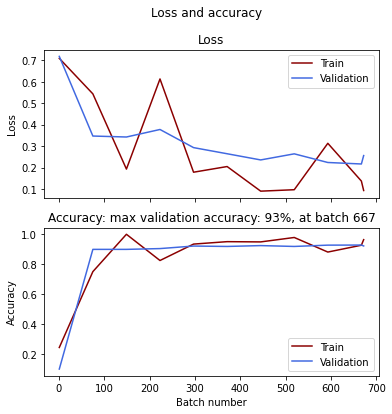

In [46]:
# ========================
# Plots: loss and accuracy
# ========================
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(6,6))

# Loss
ax1.plot(batch_nums, train_loss, label='Train', c='darkred')
ax1.plot(batch_nums, val_loss, label='Validation', c='royalblue')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Loss')

# Accuracy
ax2.plot(batch_nums, train_acc, label='Train', c='darkred')
ax2.plot(batch_nums, val_acc, label='Validation', c='royalblue')
ax2.set_xlabel('Batch number')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.set_title(f'Accuracy: max validation accuracy: {max(val_acc):.0%}, at batch {batch_nums[val_acc.index(max(val_acc))]}')

fig.suptitle('Loss and accuracy')
plt.show()

In [47]:
print('Val accuracy:', [round(i, 3) for i in val_acc])
print('Train accuracy:', [round(i, 3) for i in train_acc])

Val accuracy: [0.099, 0.899, 0.899, 0.904, 0.921, 0.919, 0.924, 0.919, 0.927, 0.928, 0.922]
Train accuracy: [0.243, 0.75, 1.0, 0.825, 0.934, 0.951, 0.949, 0.979, 0.881, 0.927, 0.964]


In [48]:
print('Val loss:', [round(i, 3) for i in val_loss])
print('Train loss:', [round(i, 3) for i in train_loss])

Val loss: [0.719, 0.347, 0.343, 0.378, 0.293, 0.265, 0.236, 0.264, 0.224, 0.217, 0.256]
Train loss: [0.709, 0.544, 0.193, 0.613, 0.178, 0.205, 0.09, 0.097, 0.313, 0.137, 0.093]


**NOTE:**

Guessing that the pixel is not cancerous every single time will give you an accuracy of ~ 85%.
Your trained network should be able to do better than that (but you will not be graded on accuracy).

# Part 3: Display model predictions

Generate at least 5 predictions on the pos_test_000072.png image and display them as images. These predictions should be made at a reasonable interval (e.g. every epoch). 

To do this, calculate the output of your trained network on the pos_test_000072.png image, then make a hard decision (cancerous/not-cancerous) for each pixel.

The resulting image should be black-and-white, where white pixels represent things you think are probably cancerous.

**TODO:**

**DONE:**
 * ✅ 5 images from training displayed below


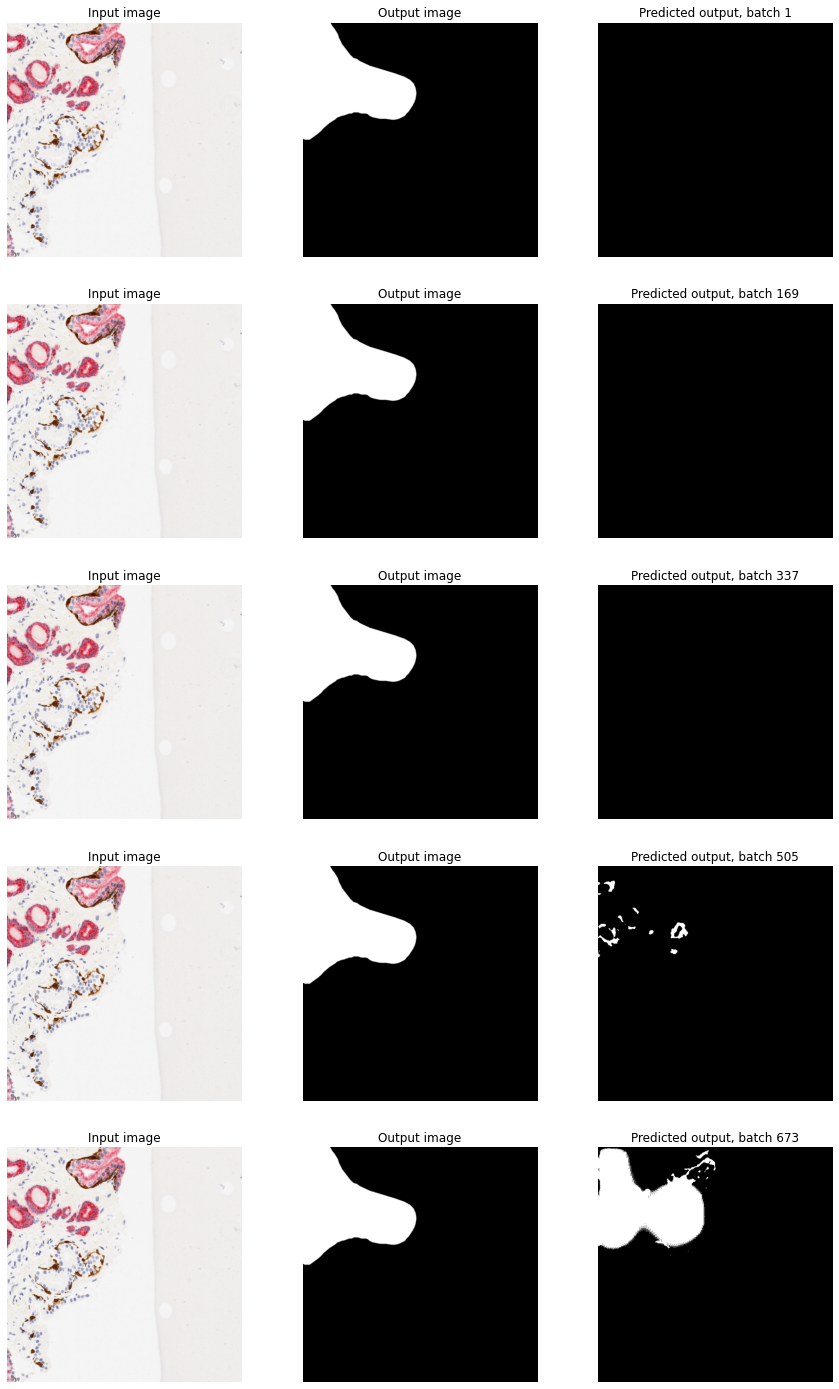

In [51]:
val_dataset = CancerDataset(root='/tmp/cancer_data', train=False)
x, y_truth = val_dataset[172]
input_img = x.numpy()
# imshow expects dimensions in the order: height x width x depth (channels)
# See: https://stackoverflow.com/a/23944468/17005348
# Alternatively, keep the array as a Tensor and use Tensor.view
input_img = np.transpose(input_img, (1, 2, 0))
output_img = y_truth.numpy()

# Plot images
plt.figure(figsize=(15, 25))

for i in range(len(batch_nums_predictions)):
    plt.subplot(5, 3, (i*3) + 1)
    plt.imshow(input_img)
    plt.title('Input image')
    # Remove axis ticks and labels
    # Alternatively, see: https://www.kite.com/python/answers/how-to-remove-axis-labels-from-a-matplotlib-figure-in-python
    plt.axis('off')

    plt.subplot(5, 3, (i*3) + 2)
    plt.imshow(output_img, cmap='gray')
    plt.title('Output image')
    plt.axis('off')

    plt.subplot(5, 3, (i*3) + 3)
    plt.imshow(predicted_images[i], cmap='gray')
    plt.title(f'Predicted output, batch {batch_nums_predictions[i]}')
    plt.axis('off')

plt.show()